#### **Import Libraries**

In [1]:
import torch
import os 
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from huggingface_hub import notebook_login
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
from transformers import DataCollatorWithPadding
import matplotlib.pyplot as plt
from datasets import Dataset
import transformers
from torch.utils.data import DataLoader
import numpy as np 
import torch
import pickle
from torch import nn
from llmft.train import evaluate_model, train_one_epoch, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict
from llmft.generate import generate_dataset
from llmft.paper import generate_recall_table

In [2]:
os.getcwd()

'/home/ubuntu/llmft/notebooks-scripts/encoder'

In [3]:
table_folder = "./../../../instrumental_llms/tables/"
figure_folder = "./../../../instrumental_llms/figures/"
temp_data = os.getcwd() + "/temp-data/"
print(temp_data)

/home/ubuntu/llmft/notebooks-scripts/encoder/temp-data/


#### **Plotting**

In [4]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')
from matplotlib import font_manager 
locations =  './../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_36pt/Newsreader_36pt-SemiBold.ttf


#### **Set Up Device**

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


#### **Tokenizer**

In [6]:
model_id = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.model_max_length = 512
print(tokenizer.model_max_length)

def tokenizer_function(example):
  return tokenizer(example["text"], truncation=True)

512


#### **Dataset**

In [7]:
# original_dataset = Dataset.from_dict(generate_dataset(total_entries=1000, flip_rate=0.1))
# dataset = original_dataset.train_test_split(test_size=0.5, seed=42)
# tokenized_dataset = dataset.map(tokenizer_function, batched=True)
# tokenized_dataset = tokenized_dataset.remove_columns("text")

original_dataset = load_dataset("ppower1/instrument")['train']
def check_prefix(example):
    example['type_indicator'] = 1 if example['text'].startswith('Yes') else 0
    return example
original_dataset = original_dataset.map(check_prefix)
original_dataset = original_dataset.shuffle(seed=42).select(range(1000))
dataset = original_dataset.train_test_split(test_size=0.5, seed=42)
tokenized_dataset = dataset.map(tokenizer_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['text', 'treated text', 'control text', 'raw_label'])

#### **Plot Histogram of Tokens**

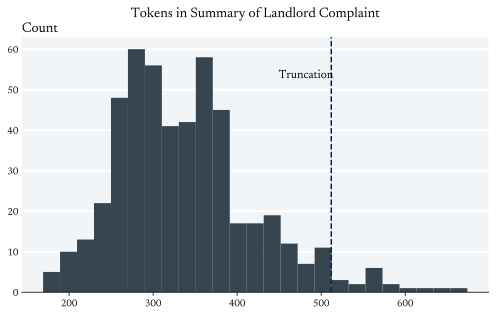

In [8]:
def count_tokens(example):
    tokens = tokenizer.tokenize(example['text'])
    return {"num_tokens": len(tokens)}

n_tokens = dataset['train'].map(count_tokens)['num_tokens']

fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
ax.set_title('Tokens in Summary of Landlord Complaint', size=14, loc='center', pad=20)

plt.hist(n_tokens, bins=25, color='#36454F')
plt.axvline(512, linestyle='--')
ax.annotate(f'Truncation',
                xy = (0.55, 0.85),
                xycoords='axes fraction',
                ha='left',
                va="center", 
                size=12)
plt.show()

#### **Hyperparameters**

In [9]:
lr = 1e-5
warmup_ratio = 15
batch_size = 16
epochs = 30
patience = float('inf') 
gamma = 0.0

training_status = 'standard' if lr==1e-4 else 'preferred'

#### **DataLoaders**

In [10]:
train_loader = DataLoader(tokenized_dataset['train'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True)
test_loader = DataLoader(tokenized_dataset['test'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer))

#### **Model**

In [11]:
labels = tokenized_dataset['train'].features['label'].names

num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label 

model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                           num_labels=num_labels,
                                                           label2id=label2id,
                                                           id2label=id2label)
model = model.to(device)
model = torch.compile(model)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **Optimizer and scheduler**

In [12]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler =transformers.optimization.get_linear_schedule_with_warmup(optimizer,int(warmup_ratio*len(train_loader)*epochs), len(train_loader)*epochs)

#### **Weight Vectors**

In [13]:
# Assume 'class_counts' is a list containing the number of samples for each class
n_samples = len(dataset['train']); print(f"Number of Observations: {n_samples}")
n_positive = sum(dataset['train']['label']); print(f"Number of Positive Outcomes: {n_positive}")
class_weights = torch.tensor([1., 1.], device=device) 
frac_positive = (n_positive/n_samples)
class_weights = torch.tensor([1/ (1-frac_positive), 1 / frac_positive], device=device)
class_weights = class_weights/sum(class_weights)
criterion = FocalLoss(alpha=class_weights, gamma=gamma, mode='output')
print(criterion.gamma)
# fraction_treated = sum(original_dataset['type_indicator'])/len(original_dataset)
# class_weights = torch.tensor([1/(1-fraction_treated), 1/fraction_treated], device=device)
# class_weights = torch.tensor([0.5, 0.5], device=device) #torch.tensor([1-total_treated/ len(original_dataset), total_treated/ len(original_dataset)], device=device)#torch.tensor([total_samples/ len(original_dataset), 1-total_samples/ len(original_dataset)], device=device)
# print(f"Relative Weights: {class_weights}")


Number of Observations: 500
Number of Positive Outcomes: 20
0.0


#### **Training**

In [14]:
evaluation_losses = [evaluate_model(model, test_loader, criterion, device)]
training_losses = [evaluate_model(model, train_loader, criterion, device)]
early_stopping = EarlyStopping(patience=patience, verbose=True)
metric_history = []
learning_rate_history = []

for epoch in range(epochs):

    train_loss, (recall, _), current_lr = train_one_epoch(model, train_loader, optimizer, scheduler, compute_recall, criterion, device)

    training_losses.append(train_loss)
    metric_history.append(recall)
    learning_rate_history.append(current_lr)
    
    val_loss = evaluate_model(model, test_loader, criterion, device)
    evaluation_losses.append(val_loss)
    
    # Call early stopping
    early_stopping(val_loss, model, epoch)
    if early_stopping.early_stop:
        print("***Early stopping***")
        print(f"Min Validation Loss: {early_stopping.best_epoch}")
        print(f"Current Epoch: {epoch}")
        break

model.load_state_dict(torch.load('checkpoint.pt'))

/home/ubuntu/llmft/llms/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:124: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Validation loss improved (0.064033). Saving model...
Validation loss improved (0.064029). Saving model...
Validation loss improved (0.064022). Saving model...
Validation loss improved (0.064014). Saving model...
Validation loss improved (0.063999). Saving model...
Validation loss improved (0.063989). Saving model...
Validation loss improved (0.063935). Saving model...
Validation loss improved (0.063897). Saving model...
Validation loss improved (0.063849). Saving model...
Validation loss improved (0.063822). Saving model...
Validation loss improved (0.063793). Saving model...
Validation loss improved (0.063739). Saving model...
Validation loss improved (0.063735). Saving model...
Validation loss improved (0.063722). Saving model...
Validation loss improved (0.063678). Saving model...
Validation loss improved (0.063675). Saving model...
Validation loss improved (0.063602). Saving model...
Validation loss improved (0.063526). Saving model...
Validation loss improved (0.063501). Saving mo

<All keys matched successfully>

#### **Save Training Runs**

In [15]:
with open(temp_data + f'{training_status}_metric.pkl', 'wb') as f:
    pickle.dump(np.array(metric_history), f)

with open(temp_data + f'{training_status}_val_loss.pkl', 'wb') as f:
    pickle.dump(evaluation_losses, f)

#### **Plot Training Runs**

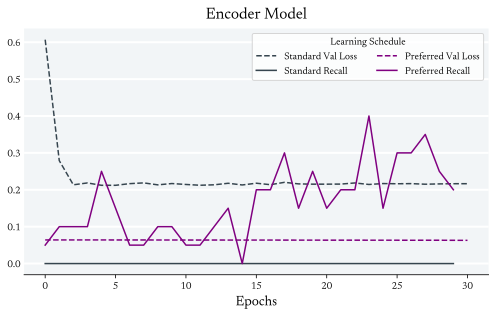

In [16]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
ax.set_title('Encoder Model', size=16, loc='center', pad=10)

for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)

for status, color in zip(['standard', 'preferred'], ['#36454F', 'purple']): #'preferred', 'purple']):
    try: 
        with open(temp_data + f'{status}_metric.pkl', 'rb') as f:
            standard_metrics =  pickle.load(f)
            
        with open(temp_data + f'{status}_val_loss.pkl', 'rb') as f:
            eval_loss =  pickle.load(f)
        
        plt.plot(eval_loss, color=color, label=status.capitalize() + ' Val Loss', linestyle='--')
        plt.plot(standard_metrics[:,1], color=color, label=status.capitalize()+ ' Recall')

    except FileNotFoundError:
        print(f"Error: You have not fit the model with {status} learning rates")
    except Exception as e:
        print(f"An error occurred: {e}")

plt.xlabel('Epochs', size=14)
plt.legend(title='Learning Schedule', ncols=2)
fig.savefig(figure_folder + 'recall_schedule.png')
plt.show()

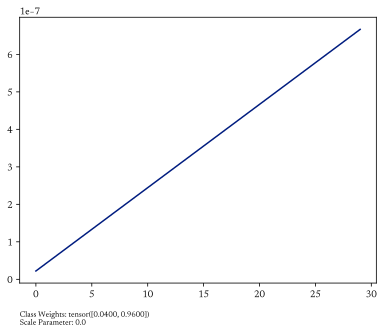

In [17]:
plt.plot(learning_rate_history)
plt.annotate(f'Class Weights: {criterion.alpha.cpu()}',
            xy = (0.0, -0.12),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=8)
plt.annotate(f'Scale Parameter: {criterion.gamma}',
            xy = (0., -0.15),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=8)
plt.show()

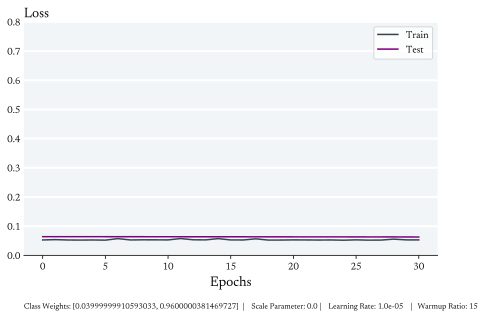

In [18]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Loss', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)

plt.plot(training_losses, label='Train', color='#36454F')
plt.plot(evaluation_losses, label='Test', color='purple')
plt.annotate(f'Class Weights: {criterion.alpha.cpu().tolist()}  |    Scale Parameter: {criterion.gamma} |    Learning Rate: {lr:.1e}    |   Warmup Ratio: {warmup_ratio}',
            xy = (0.0, -0.22),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=8)
plt.xlabel('Epochs', size=14)
plt.ylim(0,0.8)
plt.legend()
if patience == float('inf'):
    fig.savefig(figure_folder + f'losses_{training_status}.png')
plt.show()

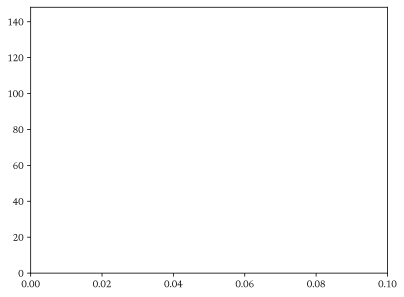

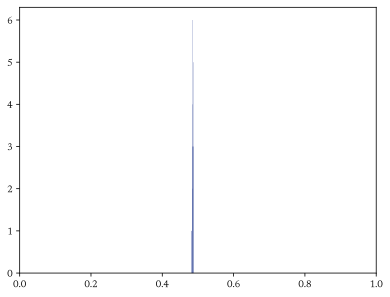

In [19]:
yhat, labels = predict(model, test_loader, device)
plt.hist(yhat[np.array(1-labels).astype(bool)])
plt.xlim(0, .1)
plt.show()
plt.hist(yhat[np.array(labels).astype(bool)])
plt.xlim(0., 1.)
plt.show()